<a href="https://colab.research.google.com/github/ZzzTheGamer/XAI/blob/Assignment/Assignment2_interpretable_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Load the dataset & Take a look at the data structure
* Here we use dataset from https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Data cleaning and preparation


*   Drop 'customerID' column



In [4]:
data.drop(columns=['customerID'], inplace=True)



*   Convert 'TotalCharges' to numeric, replace missing entries



In [5]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(subset=['TotalCharges'], inplace=True)



*   Convert target variable 'Churn' to numeric (0 for No, 1 for Yes)



In [6]:
data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})



*   Encode of categorical variables



In [7]:
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)



*   Standardize numeric features



In [8]:
# Identify numeric features for scaling
numeric_features = data.select_dtypes(include=[np.number]).columns.drop(['Churn','SeniorCitizen'])

# Apply StandardScaler to numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_features])

# Replace original numeric features with scaled values
features_scaled = pd.DataFrame(scaled_features, columns=numeric_features, index=data.index)



*   **Do outlier influence test**
*   If cook's distance exceeds the threshold, then it is a potential high impact observation point




In [9]:
# Define the independent variables and target
X = data[numeric_features]
y = data['Churn']

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

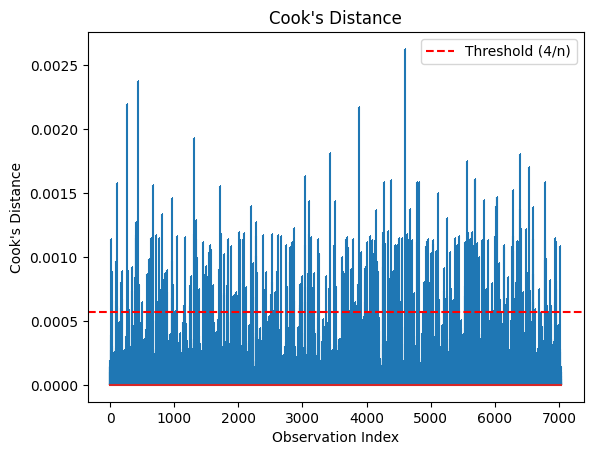

In [10]:
# Calculate Cook's Distance
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Visualize Cook's Distance
import matplotlib.pyplot as plt

plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(4 / len(X), color='r', linestyle='--', label='Threshold (4/n)')
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

In [11]:
influential_points = np.where(cooks_d > (4 / len(X)))[0]
print(f"High impact point index: {influential_points}")

High impact point index: [  22   27   31   85   97  104  115  168  178  180  185  268  272  302
  335  339  385  402  408  409  430  440  445  497  579  608  623  634
  653  657  659  677  709  752  770  797  808  809  840  853  871  887
  891  963  970  972  975 1009 1046 1157 1169 1240 1251 1259 1264 1302
 1315 1320 1323 1330 1334 1335 1360 1391 1453 1472 1489 1508 1521 1542
 1563 1570 1607 1696 1714 1719 1731 1774 1775 1779 1827 1832 1835 1885
 1898 1923 1939 1945 1962 1976 1983 2014 2024 2028 2078 2091 2093 2119
 2199 2233 2272 2275 2277 2282 2290 2382 2419 2426 2514 2521 2525 2562
 2577 2604 2609 2612 2663 2751 2764 2799 2803 2807 2832 2872 2874 2957
 2963 2968 2992 3035 3037 3038 3044 3087 3098 3106 3134 3137 3154 3180
 3236 3265 3365 3409 3433 3493 3511 3522 3615 3624 3631 3646 3673 3688
 3694 3715 3724 3750 3767 3773 3782 3784 3816 3842 3865 3883 3920 3969
 3971 3976 3998 4014 4058 4067 4076 4091 4102 4121 4124 4125 4133 4142
 4164 4173 4252 4258 4259 4265 4280 4341 4362 4387 4



*   However, we will not take any action here because when we look back at the dataset, we find that the numeric data includes tenure and total/monthly charges. For wealthy individuals, their charges can be very high, and such extreme values are meaningful. Ignoring them would risk excluding the wealthy group. Additionally, we have already scaled the data, which helps mitigate the impact of outliers.





*   Combine scaled features with encoded categorical variables and the target variable



In [12]:
encoded_columns = data.drop(columns=numeric_features).columns
data_scaled = pd.concat([features_scaled, data[encoded_columns]], axis=1)

In [13]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   float64
 1   MonthlyCharges                         7032 non-null   float64
 2   TotalCharges                           7032 non-null   float64
 3   SeniorCitizen                          7032 non-null   int64  
 4   Churn                                  7032 non-null   int64  
 5   gender_Male                            7032 non-null   bool   
 6   Partner_Yes                            7032 non-null   bool   
 7   Dependents_Yes                         7032 non-null   bool   
 8   PhoneService_Yes                       7032 non-null   bool   
 9   MultipleLines_No phone service         7032 non-null   bool   
 10  MultipleLines_Yes                      7032 non-null   bool   
 11  InternetS

In [14]:
data_scaled.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.280248,-1.161694,-0.994194,0,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0.064303,-0.260878,-0.173740,0,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,-1.239504,-0.363923,-0.959649,0,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0.512486,-0.747850,-0.195248,0,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,-1.239504,0.196178,-0.940457,0,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [15]:
data_scaled.describe()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Churn
count,7.032000e+03,7.032000e+03,7.032000e+03,7032.000000,7032.000000
mean,-1.126643e-16,6.062651e-17,-1.119064e-16,0.162400,0.265785
std,1.000071e+00,1.000071e+00,1.000071e+00,0.368844,0.441782
min,-1.280248e+00,-1.547283e+00,-9.990692e-01,0.000000,0.000000
25%,-9.542963e-01,-9.709769e-01,-8.302488e-01,0.000000,0.000000
50%,-1.394171e-01,1.845440e-01,-3.908151e-01,0.000000,0.000000
75%,9.199259e-01,8.331482e-01,6.668271e-01,0.000000,1.000000
max,1.612573e+00,1.793381e+00,2.824261e+00,1.000000,1.000000


In [16]:
data_scaled.to_csv('data_scaled_churn.csv', index=False)

## 2. Data exploration

In [17]:
# Ensure binary variables are numeric for correlation computation
data_encoded = data_scaled.copy()
data_encoded = data_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Calculate the correlation matrix
correlation_matrix = data_encoded.corr()

# Extract correlations with 'Churn' and sort them
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)

<ipython-input-17-5f2cc0cdf52e>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_encoded = data_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))


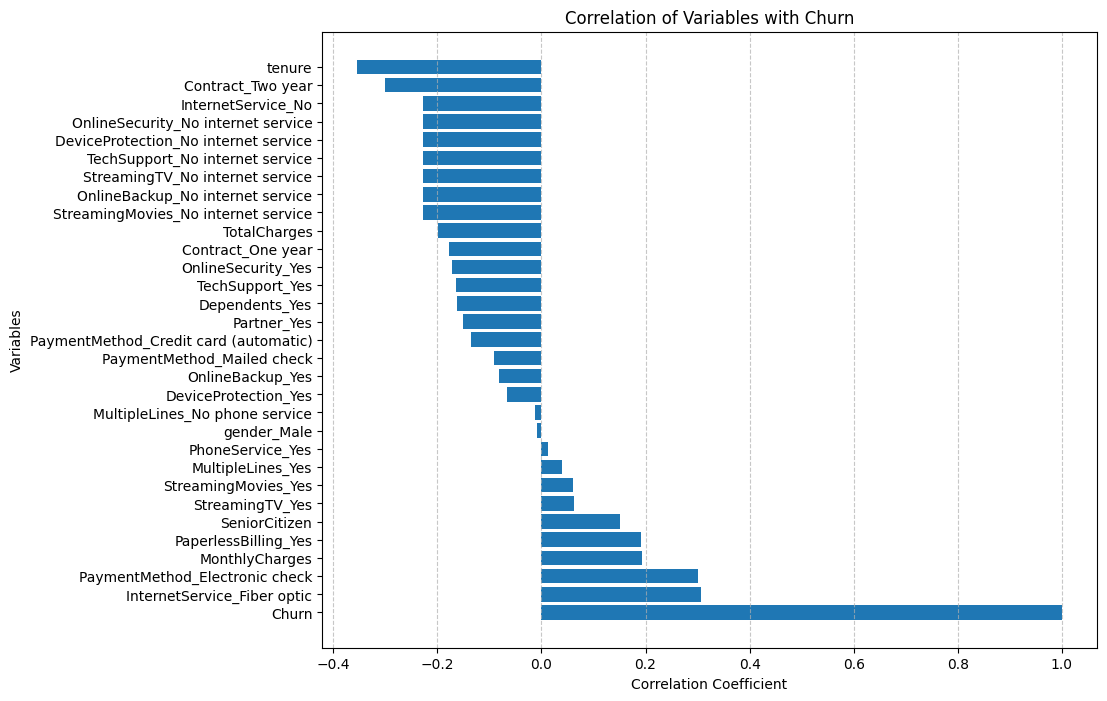

In [18]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.barh(churn_correlation.index, churn_correlation.values)
plt.title('Correlation of Variables with Churn')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



####   Here we can see how factors may influence the churn rate
1.   Negatively correlated variables
*   Tenure: Customers who have been with the company longer are less likely to churn, indicating strong customer loyalty.
*   Contract_Two year and Contract_One year: Customers with longer-term contracts tend to have lower churn rates.
*   TotalCharges: Higher total spending is associated with lower churn, possibly reflecting greater customer loyalty.
*   OnlineSecurity_Yes and TechSupport_Yes: Subscribing to additional security services or technical support reduces the likelihood of churn.
*   No InternetService: Customers without internet service are less likely to churn. This could indicate that these customers primarily use other services like TV and have fewer alternatives and incentives to leave.
2.   Positively correlated variables
*   PaymentMethod_Electronic check: Customers paying via electronic check have higher churn rates, potentially due to convenience.
*   InternetService_Fiber optic: Customers using fiber optic internet services exhibit higher churn rates, possibly due to higher costs.
*   MonthlyCharges: Higher monthly charges are linked to increased churn, indicating price-sensitive customers are more likely to leave.
*   SeniorCitizen: Older customers show slightly higher churn rates, potentially due to challenges in using technology.








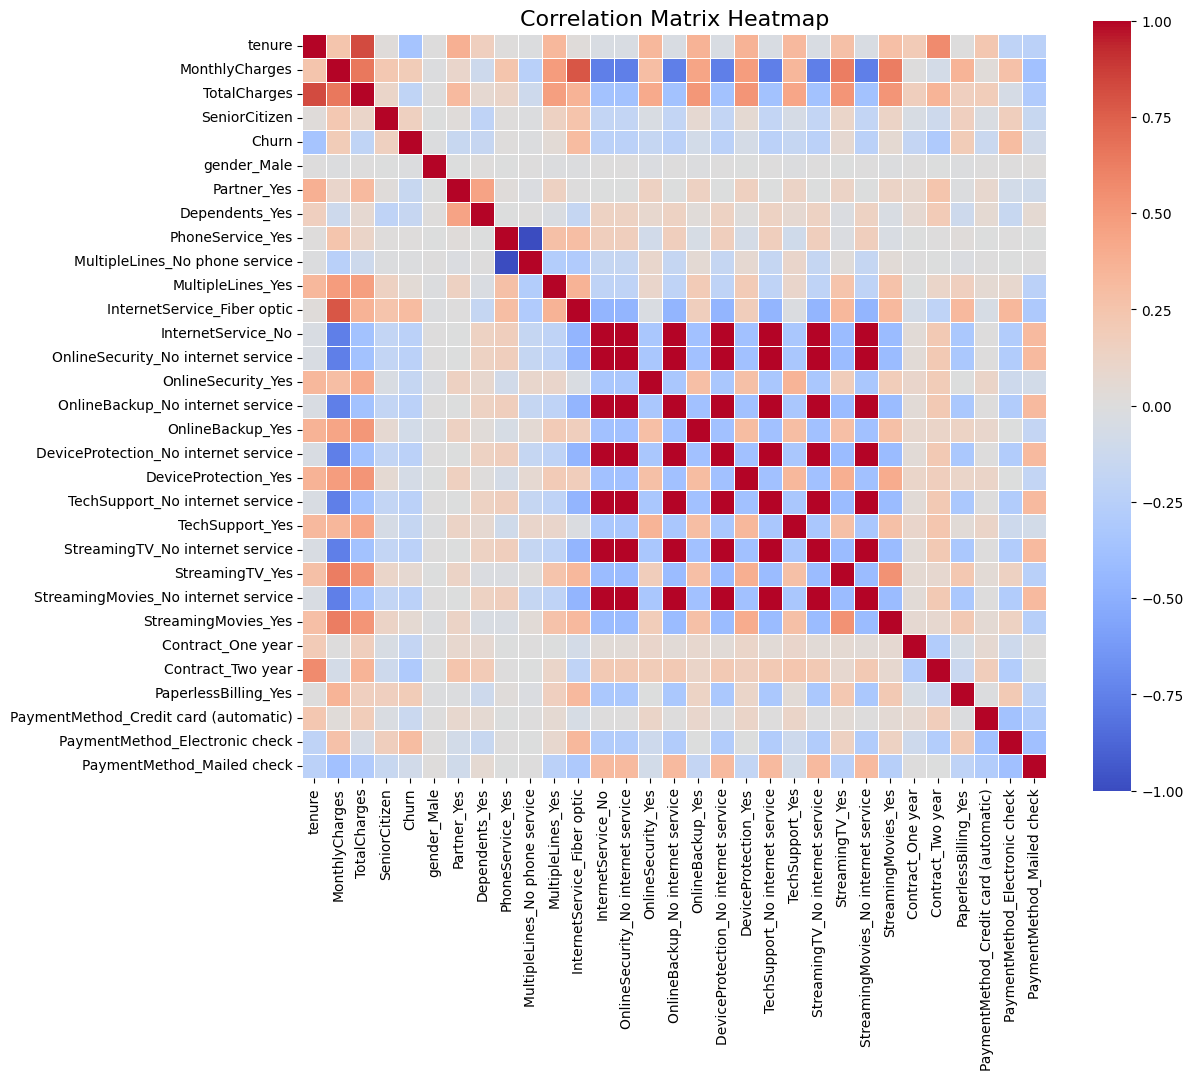

In [19]:
# Plot the full correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

*    From the overall correlation chart, we can validate the statements above. At the same time, we noticed some ***high correlations*** between non-target variables, which could potentially lead to ***multicollinearity***.


*   **Do Vif to test multicollinearity**

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare data for VIF calculation (ensure all variables are numeric)
X = data_encoded.drop(columns=['Churn'])

# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = dataframe.columns
    vif_data['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data
vif_data = calculate_vif(X)
vif_data

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,tenure,7.584453
1,MonthlyCharges,866.089640
2,TotalCharges,10.811490
3,SeniorCitizen,1.153220
4,gender_Male,1.002106
5,Partner_Yes,1.462988
6,Dependents_Yes,1.381598
7,PhoneService_Yes,354.583951
8,MultipleLines_No phone service,148.763876
9,MultipleLines_Yes,7.289761


* From the VIF chart, we observe that MonthlyCharges (866.089640) has a very high VIF, which is likely due to strong multicollinearity with TotalCharges.
* Additionally, variables such as InternetService_No, OnlineSecurity_No internet service, and OnlineBackup_No internet service show infinite VIF values, which could be influenced by the shared factor of not having internet service, indicating strong multicollinearity.
* Similarly, PhoneService_Yes also has a high VIF, suggesting potential multicollinearity with MultipleLines_Yes phone service.
* Based on these observations, we will retain one variable from each category while removing other highly collinear variables. We will then recalculate VIF to check if it meets the standard.

In [21]:
# Function to calculate VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = dataframe.columns
    vif_data['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Step 1: Drop `MonthlyCharges`
data_reduced = data_encoded.drop(columns=['MonthlyCharges', 'PhoneService_Yes', 'Churn','OnlineBackup_No internet service',
                      'DeviceProtection_No internet service','TechSupport_No internet service',
                      'TechSupport_No internet service','StreamingMovies_No internet service',
                      'OnlineSecurity_No internet service','StreamingTV_No internet service'], errors='ignore')
# Step 2: Recalculate VIF
vif_result = calculate_vif(data_reduced)
vif_result

,Feature,VIF
0,tenure,7.538121
1,TotalCharges,9.356008
2,SeniorCitizen,1.366297
3,gender_Male,1.914614
4,Partner_Yes,2.753570
5,Dependents_Yes,1.963691
6,MultipleLines_No phone service,1.515047
7,MultipleLines_Yes,2.368017
8,InternetService_Fiber optic,3.447778
9,InternetService_No,2.892806


* Here we can see all values of vif meet the standard

## 3. Linear Model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

* Split the dataset

In [23]:
# Define the target variable and features
X = data_reduced
y = data_encoded['Churn']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Define evaluation function for linear model

In [24]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X_train.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

* Here we test three linear models: Ordinary linear regression, ridge model, lasso model
* For ridge regression: It uses L2 regularization to shrink coefficients, addressing multicollinearity and overfitting while retaining all features.
* For lasso regression: It uses L1 regularization to shrink insignificant feature coefficients to zero, enabling feature selection and reducing overfitting.

In [25]:
# Fit models
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear Regression")
ridge_model, ridge_pred = evaluate_model(Ridge(alpha=1.0), X_train, X_test, y_train, y_test, "Ridge Regression")
lasso_model, lasso_pred = evaluate_model(Lasso(alpha=0.01), X_train, X_test, y_train, y_test, "Lasso Regression")


Linear Regression:
MSE: 0.15
R2 Score: 0.25
tenure: -0.0459
TotalCharges: -0.1037
SeniorCitizen: 0.0546
gender_Male: -0.0038
Partner_Yes: 0.0071
Dependents_Yes: -0.0286
MultipleLines_No phone service: 0.0307
MultipleLines_Yes: 0.0501
InternetService_Fiber optic: 0.1821
InternetService_No: -0.1416
OnlineSecurity_Yes: -0.0555
OnlineBackup_Yes: -0.0107
DeviceProtection_Yes: 0.0033
TechSupport_Yes: -0.0564
StreamingTV_Yes: 0.0557
StreamingMovies_Yes: 0.0588
Contract_One year: -0.1168
Contract_Two year: -0.0745
PaperlessBilling_Yes: 0.0360
PaymentMethod_Credit card (automatic): -0.0095
PaymentMethod_Electronic check: 0.0622
PaymentMethod_Mailed check: -0.0062

Ridge Regression:
MSE: 0.15
R2 Score: 0.25
tenure: -0.0462
TotalCharges: -0.1033
SeniorCitizen: 0.0546
gender_Male: -0.0038
Partner_Yes: 0.0071
Dependents_Yes: -0.0286
MultipleLines_No phone service: 0.0307
MultipleLines_Yes: 0.0501
InternetService_Fiber optic: 0.1818
InternetService_No: -0.1414
OnlineSecurity_Yes: -0.0555
OnlineBack

1. From the summary output, we can see the linear regression model, with an MSE of 0.15 and an R² score of 0.25, explains only 25% of the variance in the target variable, indicating limited predictive power.
2. Key insights include that longer tenure larger TotalCharges and long-term contracts (e.g., one-year and two-year contracts) reduce churn likelihood, while features like fiber-optic internet service and electronic check payments are positively associated with churn. For example, a one-unit increase in tenure decreases churn likelihood by 0.0459, while having InternetService_Fiber optic increases it by 0.1821.

* Here, we defined a function to **check the assumptions** of a linear model, which includes the following assumptions: **Linearity, Homoscedasticity, Normality of Residuals, and Independence**. **Multicollinearity and outliers** have already been detected and corrected earlier, so they are not checked again here.

In [26]:
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset

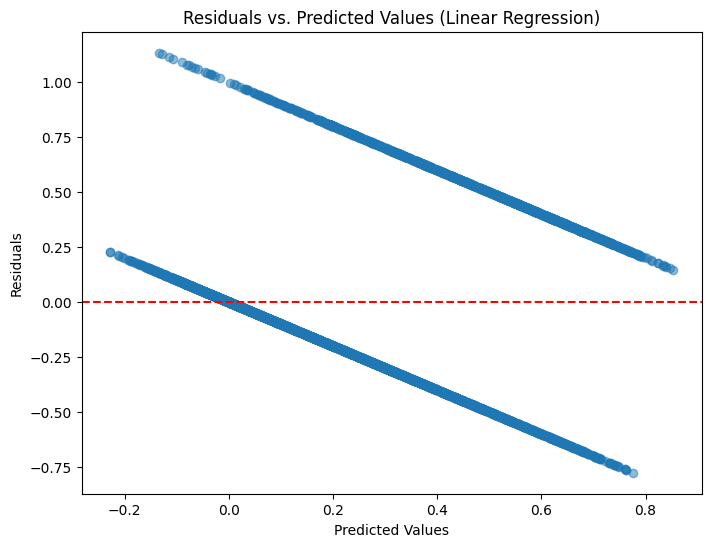

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


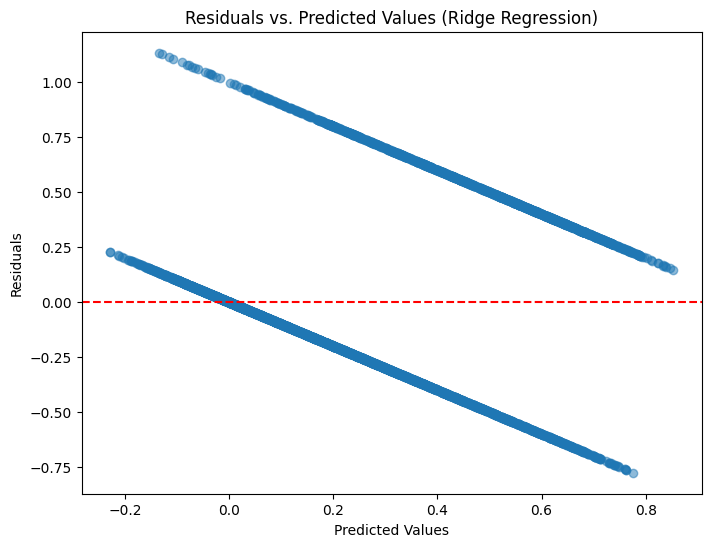

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


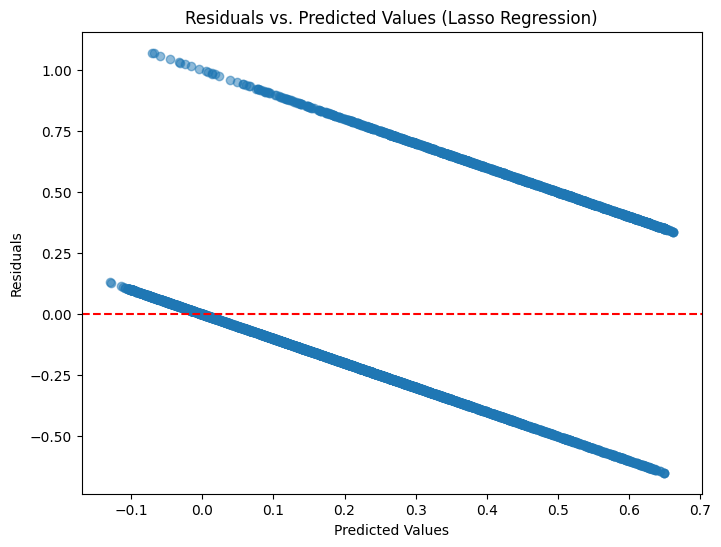

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


({'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1106.2169849483448,
   'p-value': 4.616184128465508e-220,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9643833185057585,
   'P-Value': 4.0481627775880895e-35,
   'Normality': 'Fail'},
  'Durbin-Watson Test (Independence)': 1.997006985954637},
 {'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1106.7199434918764,
   'p-value': 3.606098462641926e-220,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9643248389597091,
   'P-Value': 3.83714835278488e-35,
   'Normality': 'Fail'},
  'Durbin-Watson Test (Independence)': 1.9970019316974446},
 {'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1337.0601411963996,
   'p-value': 2.2859205854985308e-269,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9205721573197374,
   'P-Value': 1.9057223689716073e

In [27]:
def check_assumptions(model, X_train, y_train, model_name):
    # Predict on the training set
    y_train_pred = model.predict(X_train)
    residuals = y_train - y_train_pred

    # Linearity: residuals vs. predicted values plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Residuals vs. Predicted Values ({model_name})")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Homoscedasticity: Breusch-Pagan test
    X_train_with_const = sm.add_constant(X_train)
    bp_test = het_breuschpagan(residuals, X_train_with_const)
    bp_test_result = {
        "Lagrange Multiplier Statistic": bp_test[0],
        "p-value": bp_test[1],
        "Homoscedasticity": "Pass" if bp_test[1] > 0.05 else "Fail",
    }

    # Normality of residuals: Shapiro-Wilk test
    shapiro_test_stat, shapiro_p_value = shapiro(residuals)
    shapiro_test_result = {
        "Test Statistic": shapiro_test_stat,
        "P-Value": shapiro_p_value,
        "Normality": "Pass" if shapiro_p_value > 0.05 else "Fail",
    }

    # Durbin-Watson rest for independence
    durbin_watson_stat = durbin_watson(residuals)

    # Display results
    assumption_checks = {
        "Breusch-Pagan Test (Homoscedasticity)": bp_test_result,
        "Shapiro-Wilk Test (Normality)": shapiro_test_result,
        "Durbin-Watson Test (Independence)": durbin_watson_stat
    }

    return assumption_checks

# Check assumptions for all three models
lr_assumptions = check_assumptions(lr_model, X_train, y_train, "Linear Regression")
ridge_assumptions = check_assumptions(ridge_model, X_train, y_train, "Ridge Regression")
lasso_assumptions = check_assumptions(lasso_model, X_train, y_train, "Lasso Regression")

lr_assumptions, ridge_assumptions, lasso_assumptions

* Here, we can see the residual plot shows a clear stratified pattern, indicating that the linearity assumption may not hold. It may due to the binary nature of the target variable or a nonlinear relationship.
* The normality and homoscedasticity tests fail, while the independence test holds as the value of the DW test is close to 2.

* Below are my solutions. Since the target variable is binary (0 or 1, representing churn or no churn), applying a log transformation to it is neither reasonable nor meaningful. Therefore, I chose to transform the explanatory variables (independent variables). Specifically, I added interaction terms and square terms. These transformations can help address the issues with certain assumptions not being satisfied, such as **linearity** and **homoscedasticity**(nonlinear transformation can reduce the structured pattern of residuals and improve heteroscedasticity)

In [28]:
from sklearn.preprocessing import PolynomialFeatures

# Generate interaction terms (degree=2 includes original features and pairwise interactions)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = poly.fit_transform(X_train)
X_test_interaction = poly.transform(X_test)

# Convert the interaction item to a DataFrame
interaction_feature_names = poly.get_feature_names_out(X_train.columns)
X_train_interaction = pd.DataFrame(X_train_interaction, columns=interaction_feature_names, index=X_train.index)
X_test_interaction = pd.DataFrame(X_test_interaction, columns=interaction_feature_names, index=X_test.index)

In [29]:
lr_model_interaction, lr_pred_interaction = evaluate_model(LinearRegression(), X_train_interaction, X_test_interaction, y_train, y_test, "Linear Regression with Interaction Terms")
ridge_model_interaction, ridge_pred_interaction = evaluate_model(Ridge(alpha=1.0), X_train_interaction, X_test_interaction, y_train, y_test, "Ridge Regression with Interaction Terms")
lasso_model_interaction, lasso_pred_interaction = evaluate_model(Lasso(alpha=0.01), X_train_interaction, X_test_interaction, y_train, y_test, "Lasso Regression with Interaction Terms")


Linear Regression with Interaction Terms:
MSE: 0.15
R2 Score: 0.25
tenure: -0.2785
TotalCharges: 0.1726
SeniorCitizen: 0.0897
gender_Male: 0.0198
Partner_Yes: -0.0822
Dependents_Yes: 0.0289
MultipleLines_No phone service: 0.0030
MultipleLines_Yes: -0.0695
InternetService_Fiber optic: 0.1210
InternetService_No: -0.3255
OnlineSecurity_Yes: -0.0640
OnlineBackup_Yes: -0.0841
DeviceProtection_Yes: -0.0655
TechSupport_Yes: -0.0775
StreamingTV_Yes: -0.0372
StreamingMovies_Yes: -0.1064
Contract_One year: -0.1401
Contract_Two year: -0.0720
PaperlessBilling_Yes: 0.0059
PaymentMethod_Credit card (automatic): 0.0627
PaymentMethod_Electronic check: 0.0812
PaymentMethod_Mailed check: -0.0394
tenure TotalCharges: 0.0568
tenure SeniorCitizen: -0.0526
tenure gender_Male: -0.0402
tenure Partner_Yes: 0.0348
tenure Dependents_Yes: -0.0180
tenure MultipleLines_No phone service: 0.0882
tenure MultipleLines_Yes: 0.0327
tenure InternetService_Fiber optic: -0.0807
tenure InternetService_No: 0.2103
tenure Onli

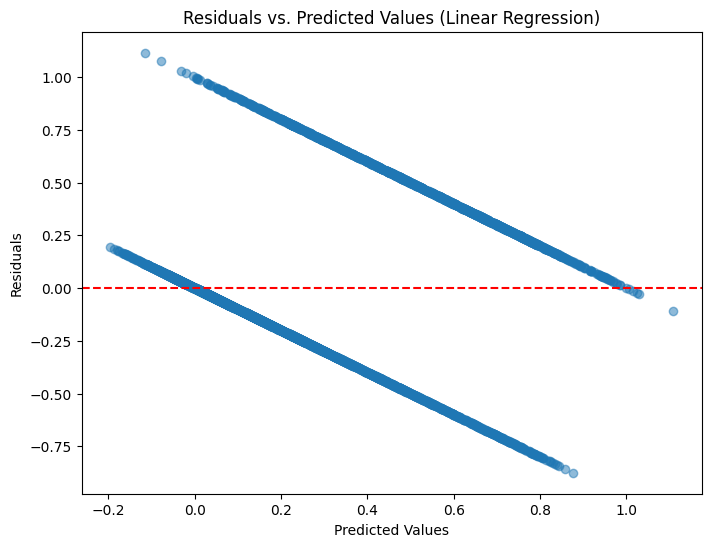

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


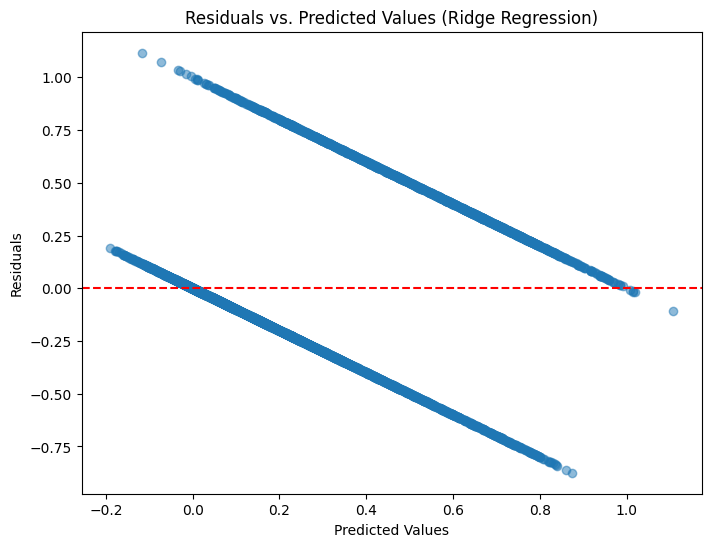

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


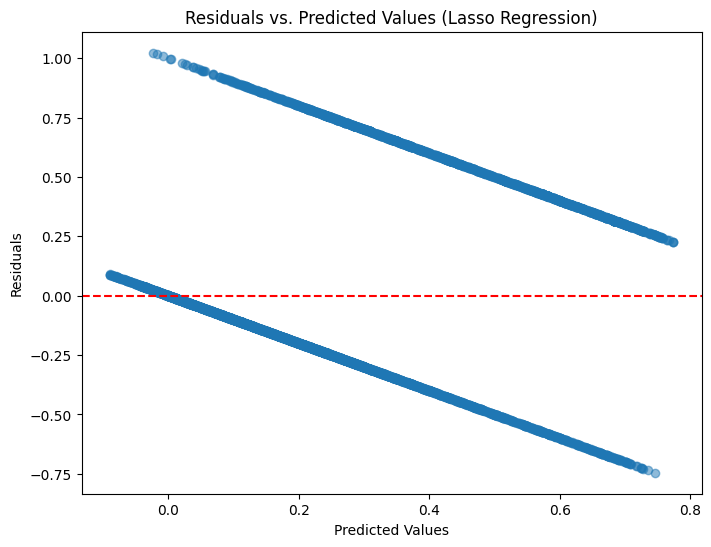

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


({'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1304.7212637296682,
   'p-value': 4.6736442354569053e-141,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9635069305782564,
   'P-Value': 1.827881619269442e-35,
   'Normality': 'Fail'},
  'Durbin-Watson Test (Independence)': 2.004643808550387},
 {'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1306.8575091886592,
   'p-value': 1.971400982659195e-141,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9630389210016678,
   'P-Value': 1.202874508372862e-35,
   'Normality': 'Fail'},
  'Durbin-Watson Test (Independence)': 2.004346298047151},
 {'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1529.4462054009516,
   'p-value': 3.29566713875601e-181,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9154745003640462,
   'P-Value': 1.7516538958812292e-4

In [30]:
# Convert transformed data to DataFrame with consistent feature names
X_train_poly = pd.DataFrame(X_train_interaction, columns=interaction_feature_names, index=X_train.index)
X_test_poly = pd.DataFrame(X_test_interaction, columns=interaction_feature_names, index=X_test.index)

# Pass these updated DataFrames to the assumption-checking function
lr_assumptions = check_assumptions(lr_model_interaction, X_train_poly, y_train, "Linear Regression")
ridge_assumptions = check_assumptions(ridge_model_interaction, X_train_poly, y_train, "Ridge Regression")
lasso_assumptions = check_assumptions(lasso_model_interaction, X_train_poly, y_train, "Lasso Regression")

lr_assumptions, ridge_assumptions, lasso_assumptions

In [31]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features (degree=2 includes original and squared terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Convert the polynomial features to a DataFrame
poly_feature_names = poly.get_feature_names_out(X_train.columns)
X_train_poly = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train.index)
X_test_poly = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=X_test.index)

# Evaluate models with polynomial features
lr_model_poly, lr_pred_poly = evaluate_model(LinearRegression(), X_train_poly, X_test_poly, y_train, y_test, "Linear Regression with Polynomial Features")
ridge_model_poly, ridge_pred_poly = evaluate_model(Ridge(alpha=1.0), X_train_poly, X_test_poly, y_train, y_test, "Ridge Regression with Polynomial Features")
lasso_model_poly, lasso_pred_poly = evaluate_model(Lasso(alpha=0.01), X_train_poly, X_test_poly, y_train, y_test, "Lasso Regression with Polynomial Features")


Linear Regression with Polynomial Features:
MSE: 0.15
R2 Score: 0.25
tenure: -0.2253
TotalCharges: 0.0818
SeniorCitizen: 0.0467
gender_Male: 0.0116
Partner_Yes: -0.0403
Dependents_Yes: 0.0141
MultipleLines_No phone service: -0.0058
MultipleLines_Yes: -0.0279
InternetService_Fiber optic: 0.0759
InternetService_No: -0.1748
OnlineSecurity_Yes: -0.0263
OnlineBackup_Yes: -0.0354
DeviceProtection_Yes: -0.0271
TechSupport_Yes: -0.0323
StreamingTV_Yes: -0.0123
StreamingMovies_Yes: -0.0463
Contract_One year: -0.0572
Contract_Two year: -0.0153
PaperlessBilling_Yes: 0.0028
PaymentMethod_Credit card (automatic): 0.0309
PaymentMethod_Electronic check: 0.0386
PaymentMethod_Mailed check: -0.0184
tenure^2: 0.0339
tenure TotalCharges: 0.0794
tenure SeniorCitizen: -0.0595
tenure gender_Male: -0.0425
tenure Partner_Yes: 0.0202
tenure Dependents_Yes: -0.0121
tenure MultipleLines_No phone service: 0.0925
tenure MultipleLines_Yes: 0.0138
tenure InternetService_Fiber optic: -0.1124
tenure InternetService_No

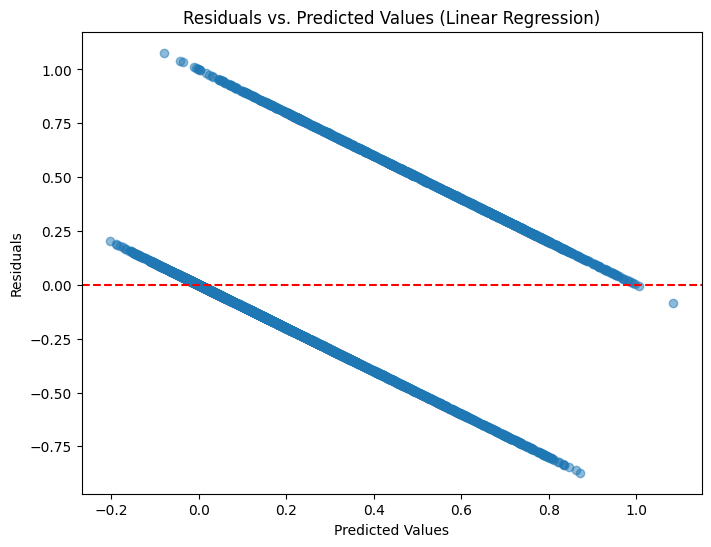

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


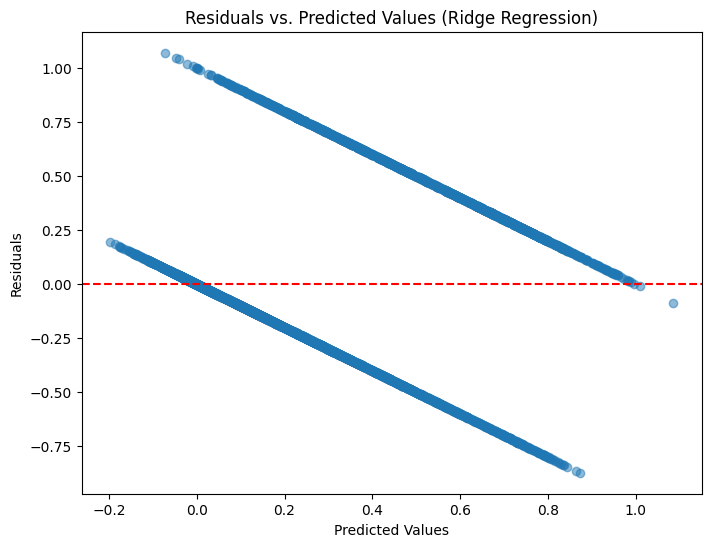

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


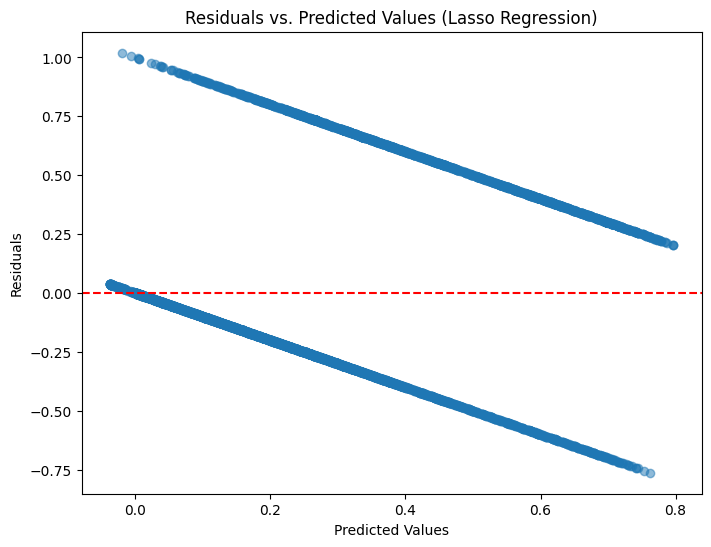

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5625.
  res = hypotest_fun_out(*samples, **kwds)


({'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1317.5484238082706,
   'p-value': 1.3329987580066182e-135,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9645206896831043,
   'P-Value': 4.591879772734124e-35,
   'Normality': 'Fail'},
  'Durbin-Watson Test (Independence)': 2.0042518834623007},
 {'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1319.9750020510312,
   'p-value': 5.090698073901532e-136,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9641763842043128,
   'P-Value': 3.350603496852429e-35,
   'Normality': 'Fail'},
  'Durbin-Watson Test (Independence)': 2.004014191920795},
 {'Breusch-Pagan Test (Homoscedasticity)': {'Lagrange Multiplier Statistic': 1535.1482065089133,
   'p-value': 8.303965190169462e-174,
   'Homoscedasticity': 'Fail'},
  'Shapiro-Wilk Test (Normality)': {'Test Statistic': 0.9152517562184921,
   'P-Value': 1.5824688449270183e

In [32]:
# Pass these updated DataFrames to the assumption-checking function
lr_assumptions = check_assumptions(lr_model_poly, X_train_poly, y_train, "Linear Regression")
ridge_assumptions = check_assumptions(ridge_model_poly, X_train_poly, y_train, "Ridge Regression")
lasso_assumptions = check_assumptions(lasso_model_poly, X_train_poly, y_train, "Lasso Regression")

lr_assumptions, ridge_assumptions, lasso_assumptions

* From this, we can see that even after adding interaction terms and square terms, the performance of the linear model has not significantly improved, and the assumptions are still not satisfied.
* To avoid collinearity and improve interpretation, we choose to proceed with the initial model for interpretation.

<Figure size 1200x600 with 0 Axes>

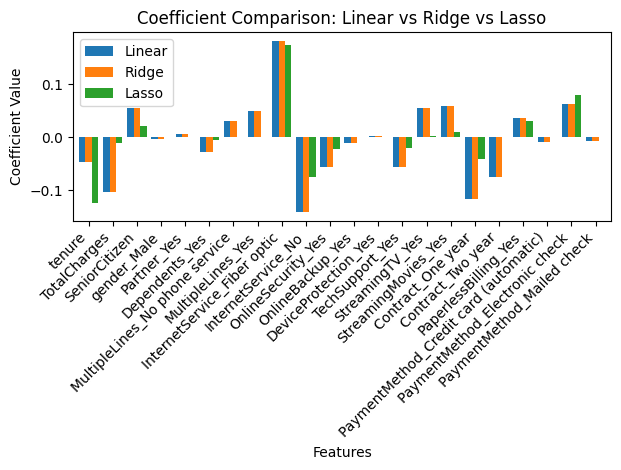

In [33]:
# Coefficient Comparison Plot
def plot_coefficients(lr_model, ridge_model, lasso_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
        'Ridge': ridge_model.coef_,
        'Lasso': lasso_model.coef_
    }, index=X.columns)

    plt.figure(figsize=(12, 6))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Comparison: Linear vs Ridge vs Lasso')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(lr_model, ridge_model, lasso_model)

* From this graph, we can see that for the linear regression model, certain features (such as tenure, Contract_Two year, and InternetService_Fiber optic) have larger coefficients, indicating their significant impact on the target variable.
* Both Ridge and Lasso retain the importance of these features, but Lasso reduces the coefficients of less significant features (such as PhoneService_Yes and OnlineBackup_Yes) to zero, suggesting these features have lower importance.
* The key features identified as important across all models (Linear, Ridge, and Lasso) are tenure, InternetService_Fiber optic, InternetService_No, Contract_One year, and PaymentMethod_Electronic check. Tenure and Contract_One year act as protective features, reducing churn with their negative coefficients, while Fiber optic and Electronic check increase churn risk with positive coefficients. Additionally, InternetService_No is a significant feature indicating that customers without internet service are less likely to churn. These are consistent with those previously found in the correlation matrix section, where more detailed explanations have been explained without attribution explanations.

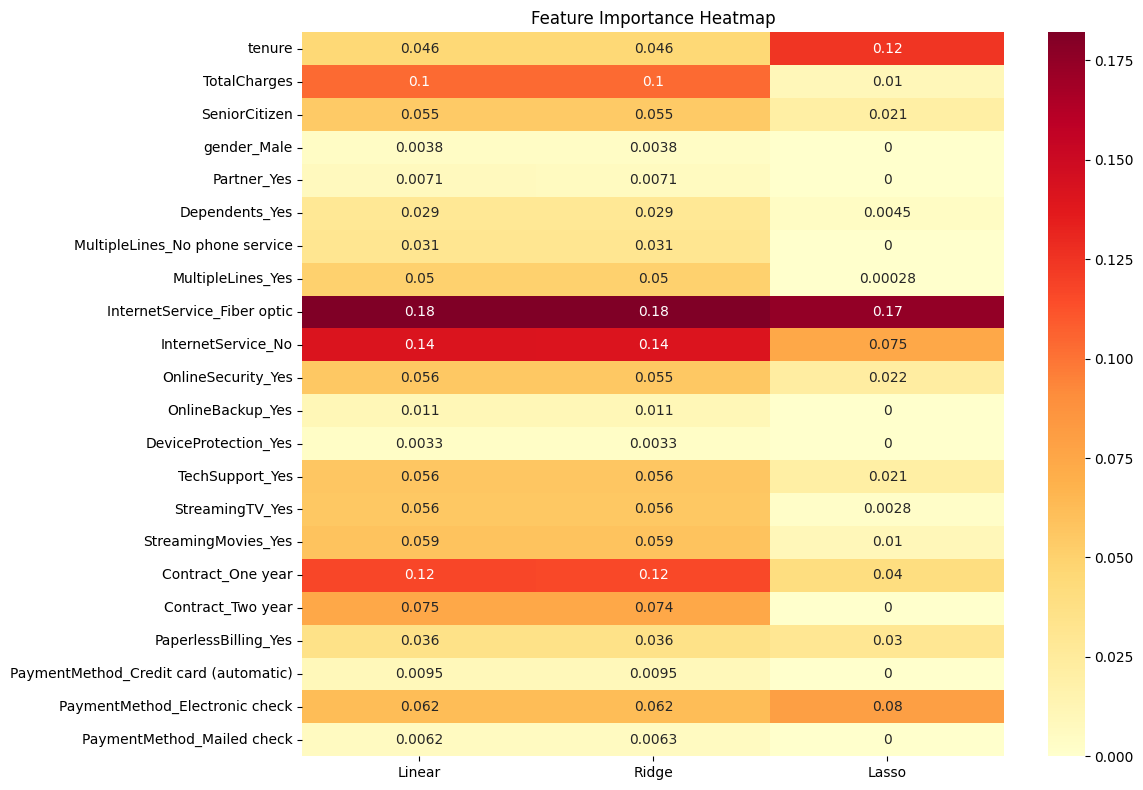

In [34]:
# Feature Importance Heatmap
def plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_),
        'Ridge': np.abs(ridge_model.coef_),
        'Lasso': np.abs(lasso_model.coef_)
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model)

* This heatmap illustrates feature importance across three models (Linear, Ridge, and Lasso). Key features such as **InternetService_Fiber optic, Contract_One year, PaymentMethod_Electronic check, InternetService_No and Tenure** consistently show high importance across all models, indicating their strong influence on churn.
* In contrast, less impactful features such as **gender_Male, Dependents_Yes, and OnlineBackup_Yes** are compressed to zero in Lasso. At the same time, for some relatively important variables of the first two models like **total charges and onlineSecurity_yes**, lasso also penalizes their coefficients, making them less important.
* Ridge does not change much with respect to linear coefficients.

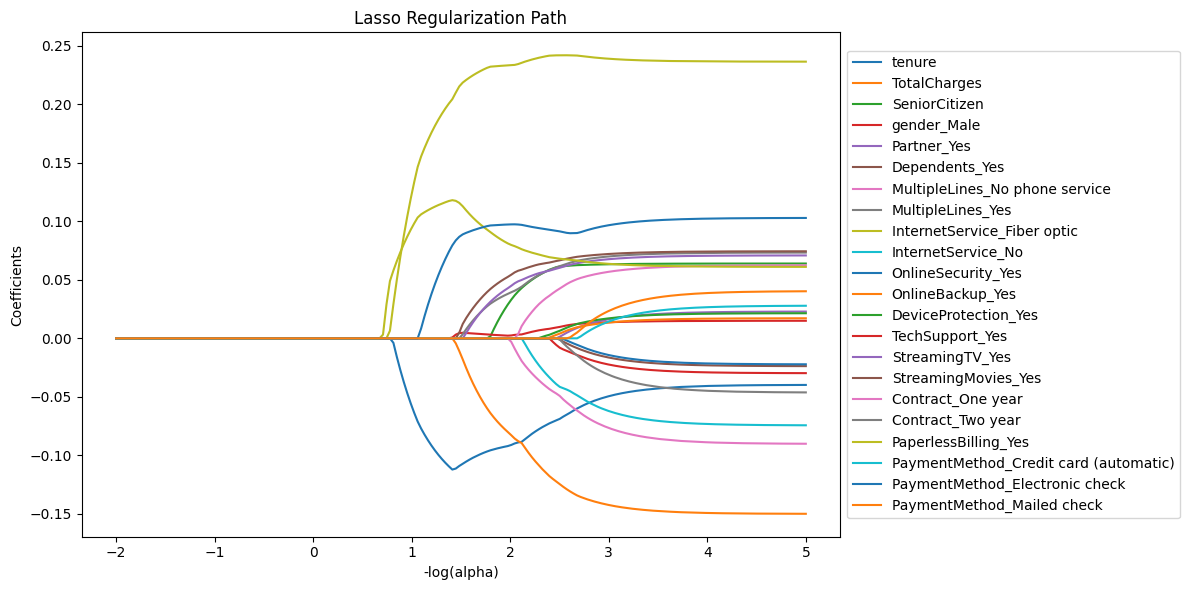

In [35]:
# Regularization Path for Lasso
from sklearn.linear_model import lasso_path

# Plot Lasso Regularization Path
def plot_lasso_path(X, y, feature_names):
    alphas, coefs, _ = lasso_path(X, y, alphas=np.logspace(-5, 2, 200))
    plt.figure(figsize=(12, 6))
    for coef_path, feature in zip(coefs, feature_names):
        plt.plot(-np.log10(alphas), coef_path, label=feature)
    plt.xlabel('-log(alpha)')
    plt.ylabel('Coefficients')
    plt.title('Lasso Regularization Path')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_lasso_path(X_train, y_train, X.columns)

* This plot illustrates the Lasso regularization path, showing how feature coefficients change as the regularization strength alpha increases. Key features like **tenure**, **InternetService_Fiber optic**, **Contract_One year**, and **PaymentMethod_Electronic check** retain significant coefficients even under strong regularization, indicating their importance. In contrast, less significant features such as **gender_Male**, **Dependents_Yes**, and **DeviceProtection_Yes** are quickly shrunk to zero.


## 4. Logistic Regression

* Since the target variable is binary and the linear model fails to meet the required assumptions, using a sigmoid model, such as logistic regression, would be a better choice.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from scipy.stats import shapiro

* Logistic Regression Model

In [37]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

* Here, we define a unified evaluation model for handling classification problems. The evaluation metrics include **accuracy, precision, recall, F1 score, and ROC AUC value.**

In [38]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, threshold=0.5):
    if hasattr(model, 'predict_proba'):
        # Models with probability output
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Models with direct prediction output
        y_pred_proba = model.predict(X_test)

    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_value = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC Curve (AUC = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Return evaluation metrics
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc_value,
        "Confusion Matrix": conf_matrix.tolist()
    }

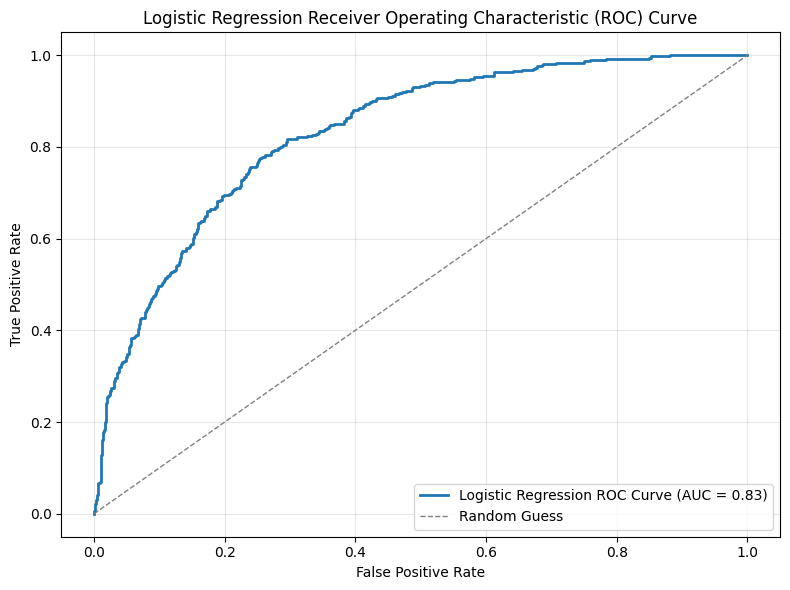

{'Model': 'Logistic Regression', 'Accuracy': 0.7889125799573561, 'Precision': 0.6254071661237784, 'Recall': 0.5133689839572193, 'F1 Score': 0.5638766519823789, 'ROC AUC': 0.8319105869928717, 'Confusion Matrix': [[918, 115], [182, 192]]}


In [39]:
logistic_eval = evaluate_model(logistic_model, X_train, X_test, y_train, y_test, "Logistic Regression")
print(logistic_eval)

1. This ROC curve and evaluation metrics reflect the performance of the logistic regression model on a classification task.
2. The ROC curve shows the model's ability to distinguish between positive and negative classes at different thresholds, with an AUC score of 0.83, indicating good discriminatory power (an 83% probability of correctly distinguishing between positive and negative samples).
3. The model achieves an accuracy of 78.9%, meaning it correctly predicts 78.9% of all samples. However, the precision (62.5%) indicates that only 62.5% of the samples predicted as positive are actual positives, while the recall (51.3%) reveals that the model identifies only 51.3% of all true positives, suggesting room for improvement in detecting positive cases.
4. The F1 score (56.4%) balances precision and recall. The F1 Score is not high, indicating that the model still has room for improvement in the prediction of positive samples.
5. To improve, strategies like adjusting the decision threshold to enhance recall, optimizing feature engineering, balancing the dataset to handle potential class imbalance, or exploring more complex models like random forests or gradient boosting can be considered.

* **Logistic regression assumption checks (influential outliers and multicollinearity were tested earlier)**
* **Test for linearity assumption and converge assumption**

In [40]:
# Add a log interaction for the Box-Tidwell Test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_train_log = X_train_scaled.copy()

for col in X_train.columns:
    X_train_log[f"{col}_log"] = X_train_scaled[col] * np.log(np.abs(X_train_scaled[col] + 1e-10))

# Fit the model using statsmodels
X_train_log.index = y_train.index
X_train_log = sm.add_constant(X_train_log)
logit_model = sm.Logit(y_train, X_train_log).fit()

# Check the significance level and converge information
print(logit_model.summary())
print(logit_model.mle_retvals)

         Current function value: 0.406909
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5625
Model:                          Logit   Df Residuals:                     5600
Method:                           MLE   Df Model:                           24
Date:                Sun, 19 Jan 2025   Pseudo R-squ.:                  0.2972
Time:                        01:48:55   Log-Likelihood:                -2288.9
converged:                      False   LL-Null:                       -3257.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -0.4395   1.75e+06  -2.51e-07      1.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### Here we check the linearity assumption:
The linearity assumption in logistic regression suggests that independent variables should have a linear relationship with the log-odds of the dependent variable. To verify this, log interaction terms (e.g., tenure_log, TotalCharges_log) were added, and their p-values were examined. Variables like tenure and TotalCharges had p-values < 0.05 for their log interactions, indicating nonlinearity and the need for transformations. Other variables, such as SeniorCitizen and gender_Male, had non-significant log interactions (p-values of NaN or 1), suggesting they might satisfy the linearity assumption but contribute little to the model. Therefore, transformations are necessary to improve the model fit.

##### We also observe the following issues:
1. Maximum Likelihood optimization failed to converge.
2. Coefficients and standard errors of some variables (e.g., SeniorCitizen) are NaN.
3. warnflag: 1 and converged: False.
4. These indicate that the model failed to converge within the maximum number of iterations, likely due to the following reasons (should check and address further):
Perfect separation: Some variables might perfectly predict the target class, causing coefficient divergence. Insufficient iterations: The default maximum iteration limit may not be adequate for the model to converge. High-dimensional features: The number of features relative to the data size may make optimization challenging.

* **Test for perfect separation**

In [41]:
for col in X_train.columns:
    print(f"{col}: {data_encoded.groupby(col)['Churn'].nunique().max()} unique values in target")

tenure: 2 unique values in target
TotalCharges: 2 unique values in target
SeniorCitizen: 2 unique values in target
gender_Male: 2 unique values in target
Partner_Yes: 2 unique values in target
Dependents_Yes: 2 unique values in target
MultipleLines_No phone service: 2 unique values in target
MultipleLines_Yes: 2 unique values in target
InternetService_Fiber optic: 2 unique values in target
InternetService_No: 2 unique values in target
OnlineSecurity_Yes: 2 unique values in target
OnlineBackup_Yes: 2 unique values in target
DeviceProtection_Yes: 2 unique values in target
TechSupport_Yes: 2 unique values in target
StreamingTV_Yes: 2 unique values in target
StreamingMovies_Yes: 2 unique values in target
Contract_One year: 2 unique values in target
Contract_Two year: 2 unique values in target
PaperlessBilling_Yes: 2 unique values in target
PaymentMethod_Credit card (automatic): 2 unique values in target
PaymentMethod_Electronic check: 2 unique values in target
PaymentMethod_Mailed check: 2

###### The fact that each independent variable (col) corresponds to 2 unique values in the target variable (Churn), rather than 1, indicates that there is no perfect separation.

* **Test for independence of observations**

In [42]:
# residual calculation
residuals = y_train - logistic_model.predict_proba(X_train)[:, 1]

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 1.995491983799906


###### The Durbin-Watson statistic of 1.995 is very close to 2, which indicates that the residuals of your logistic regression model are independent.

* **Test for large sample size**

In [43]:
# Check whether the number of positive and negative samples is sufficient
positive_count = sum(y_train == 1)
negative_count = sum(y_train == 0)
num_predictors = X_train.shape[1]

print(f"Positive samples: {positive_count}")
print(f"Negative samples: {negative_count}")
print(f"Required minimum samples per class: {10 * num_predictors}")

Positive samples: 1495
Negative samples: 4130
Required minimum samples per class: 220


###### We can see the current sample distribution (number of positive and negative samples, both of which are smaller than the minumum number required per class) meets the sample size requirements of logistic regression.



* **Test for class imbalance**

In [44]:
# Calculate class distribution
class_counts = y_train.value_counts()
# Calculate and display proportions
class_proportions = class_counts / len(y_train)
print(class_proportions)

Churn
0    0.734222
1    0.265778
Name: count, dtype: float64


###### This indicates a class imbalance, as the majority class (Non-Churn) accounts for nearly three-fourths of the data, while the minority class (Churn) makes up only about one-fourth.

###### Here we use weighted logistic regression with class_weight='balanced to refine the model. It helps address the issue of imbalanced class distribution by assigning higher weights to the minority class and lower weights to the majority class. While it does not directly resolve assumptions like linearity or independence, it mitigates the perfect separation issue that can arise when the minority class is underrepresented. Additionally, it indirectly improves model stability by making the loss function more sensitive to underrepresented samples, thereby addressing convergence challenges in imbalanced datasets.

In [45]:
from sklearn.metrics import classification_report
# Use weighted logistic regression
logistic_model_weighted = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced')
logistic_model_weighted.fit(X_train, y_train)

# Check weighted model
y_pred_weighted = logistic_model_weighted.predict(X_test)
print("\nConfusion Matrix (Weighted):")
print(confusion_matrix(y_test, y_pred_weighted))
print("\nClassification Report (Weighted):")
print(classification_report(y_test, y_pred_weighted))


Confusion Matrix (Weighted):
[[734 299]
 [ 78 296]]

Classification Report (Weighted):
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407



1. From the graph, we can see the unweighted logistic regression model achieves higher accuracy (78.9%) and precision (62.5%) compared to the weighted model (73% accuracy and 50% precision). This is because the unweighted model prioritizes the majority negative class (non-churn), resulting in fewer false positives (115 vs. 299).
2. However, the weighted model significantly improves recall for the positive class (churn), increasing it from 51.3% to 79%, which reduces false negatives (182 to 78).
3. The F1 score of the weighted model (61%) is higher than the unweighted model's (56.4%), as it balances the trade-off between precision and recall better for the positive class.
4. While the unweighted model is more precise and overall accurate, the weighted model is better at identifying churned customers, making it suitable when minimizing churn is the priority despite more false alarms.

* **Visualize logistic regression coefficient**

<Figure size 1000x600 with 0 Axes>

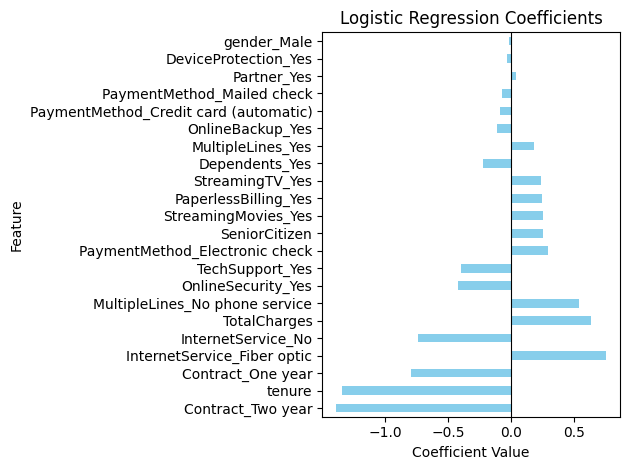

Coefficients:
tenure: -1.3430077597686136
TotalCharges: 0.6381246063338682
SeniorCitizen: 0.2599291286802606
gender_Male: -0.015375905302512365
Partner_Yes: 0.041601882613578604
Dependents_Yes: -0.21885207583038055
MultipleLines_No phone service: 0.5453282721470917
MultipleLines_Yes: 0.18620800338575752
InternetService_Fiber optic: 0.7604649600830578
InternetService_No: -0.7341027963595824
OnlineSecurity_Yes: -0.4196294089336853
OnlineBackup_Yes: -0.10882714659489724
DeviceProtection_Yes: -0.03233930240597246
TechSupport_Yes: -0.3917247778832172
StreamingTV_Yes: 0.24366973333804737
StreamingMovies_Yes: 0.2538579237364492
Contract_One year: -0.7954918272498475
Contract_Two year: -1.3919610381227454
PaperlessBilling_Yes: 0.2495981619172903
PaymentMethod_Credit card (automatic): -0.0890335633283825
PaymentMethod_Electronic check: 0.29539506487226136
PaymentMethod_Mailed check: -0.0690912903404161


In [46]:
# Extract feature names and coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logistic_model_weighted.coef_[0]
})

# Sort coefficients by absolute value
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the coefficients
plt.figure(figsize=(10, 6))
coefficients.plot(kind='barh', x='Feature', y='Coefficient', legend=False, color='skyblue')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the coefficients
print("Coefficients:")
for feature, coef in zip(X_train.columns, logistic_model_weighted.coef_[0]):
    print(f"{feature}: {coef}")

1. The plot highlights key features influencing churn. Positive coefficients identify factors increasing churn risk ( increase the likelihood of the target being 1), while negative coefficients point to factors reducing churn. For example, TotalCharges, InternetService_Fiber optic, and PaymentMethod_Electronic check have positive coefficients, indicating that these features are associated with a higher probability of churn.  Contract_Two year, tenure, and OnlineSecurity_Yes have negative coefficients, meaning they are associated with a lower likelihood of churn.
2. Features with larger absolute values have the stronger impact on customer behavior. Larger absolute values (e.g., Contract_Two year, tenure) indicate stronger influence on the target. Smaller absolute values (e.g., gender_Male, DeviceProtection_Yes) have minimal impact on predicting churn.
3. In more details, if we use numerical variables interpretation by odds, for example, we could say increasing tenure by 1 unit decreases the odds of churn by a factor of exp(−1.3430)≈0.261, meaning the odds of churn reduce by approximately 73.9% per additional unit of tenure.

## 5. GAM Model

In [47]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 30.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [48]:
from pygam import LinearGAM, GammaGAM, s
# Make sure X_train and y_train are NumPy arrays
X_train = X_train.values if hasattr(X_train, 'values') else X_train
y_train = y_train.values if hasattr(y_train, 'values') else y_train

# The formula of dynamically constructing GAM
num_features = X_train.shape[1]
# Initializes the first smoothing term
formula = s(0)
for i in range(1, num_features):
    # Add smooth entries dynamically
    formula += s(i)

# Initialize the GAM model
gam = LinearGAM(formula)

# Grid search smoothing parameters
gam.gridsearch(X_train, y_train)

# Fit model
gam.fit(X_train, y_train)

# Generate prediction
y_pred_gam = gam.predict(X_test)

100% (11 of 11) |########################| Elapsed Time: 0:01:05 Time:  0:01:05


In [49]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     35.8831
Link Function:                     IdentityLink Log Likelihood:                                -14730.2587
Number of Samples:                         5625 AIC:                                            29534.2836
                                                AICc:                                           29534.7837
                                                GCV:                                                0.1354
                                                Scale:                                              0.1339
                                                Pseudo R-Squared:                                   0.3182
Feature Function                  Lam

<ipython-input-49-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [50]:
# See which feature corresponds to each s
feature_names = data_reduced.columns.to_list()
for i, feature in enumerate(feature_names):
    print(f"s({i}) corresponds to feature: {feature}")

s(0) corresponds to feature: tenure
s(1) corresponds to feature: TotalCharges
s(2) corresponds to feature: SeniorCitizen
s(3) corresponds to feature: gender_Male
s(4) corresponds to feature: Partner_Yes
s(5) corresponds to feature: Dependents_Yes
s(6) corresponds to feature: MultipleLines_No phone service
s(7) corresponds to feature: MultipleLines_Yes
s(8) corresponds to feature: InternetService_Fiber optic
s(9) corresponds to feature: InternetService_No
s(10) corresponds to feature: OnlineSecurity_Yes
s(11) corresponds to feature: OnlineBackup_Yes
s(12) corresponds to feature: DeviceProtection_Yes
s(13) corresponds to feature: TechSupport_Yes
s(14) corresponds to feature: StreamingTV_Yes
s(15) corresponds to feature: StreamingMovies_Yes
s(16) corresponds to feature: Contract_One year
s(17) corresponds to feature: Contract_Two year
s(18) corresponds to feature: PaperlessBilling_Yes
s(19) corresponds to feature: PaymentMethod_Credit card (automatic)
s(20) corresponds to feature: Payment

1. The results of the Generalized Additive Model (GAM) provide insights into the relationship between each feature and customer churn, which accounts for nonlinear effects.
2. Key significant features (e.g., tenure, TotalCharges, SeniorCitizen, MultipleLines_Yes, InternetService_Fiber optic, InternetService_No, and contract types...) demonstrate strong statistical significance (p-values close to zero), suggesting they are crucial predictors of churn.
3. On the other hand, non-significant features such as gender, whether a customer has dependents, or some payment methods (e.g., credit card automatic payment) exhibit little to no influence on churn, reflecting their limited explanatory power in the model.

*  **Visualize GAM**

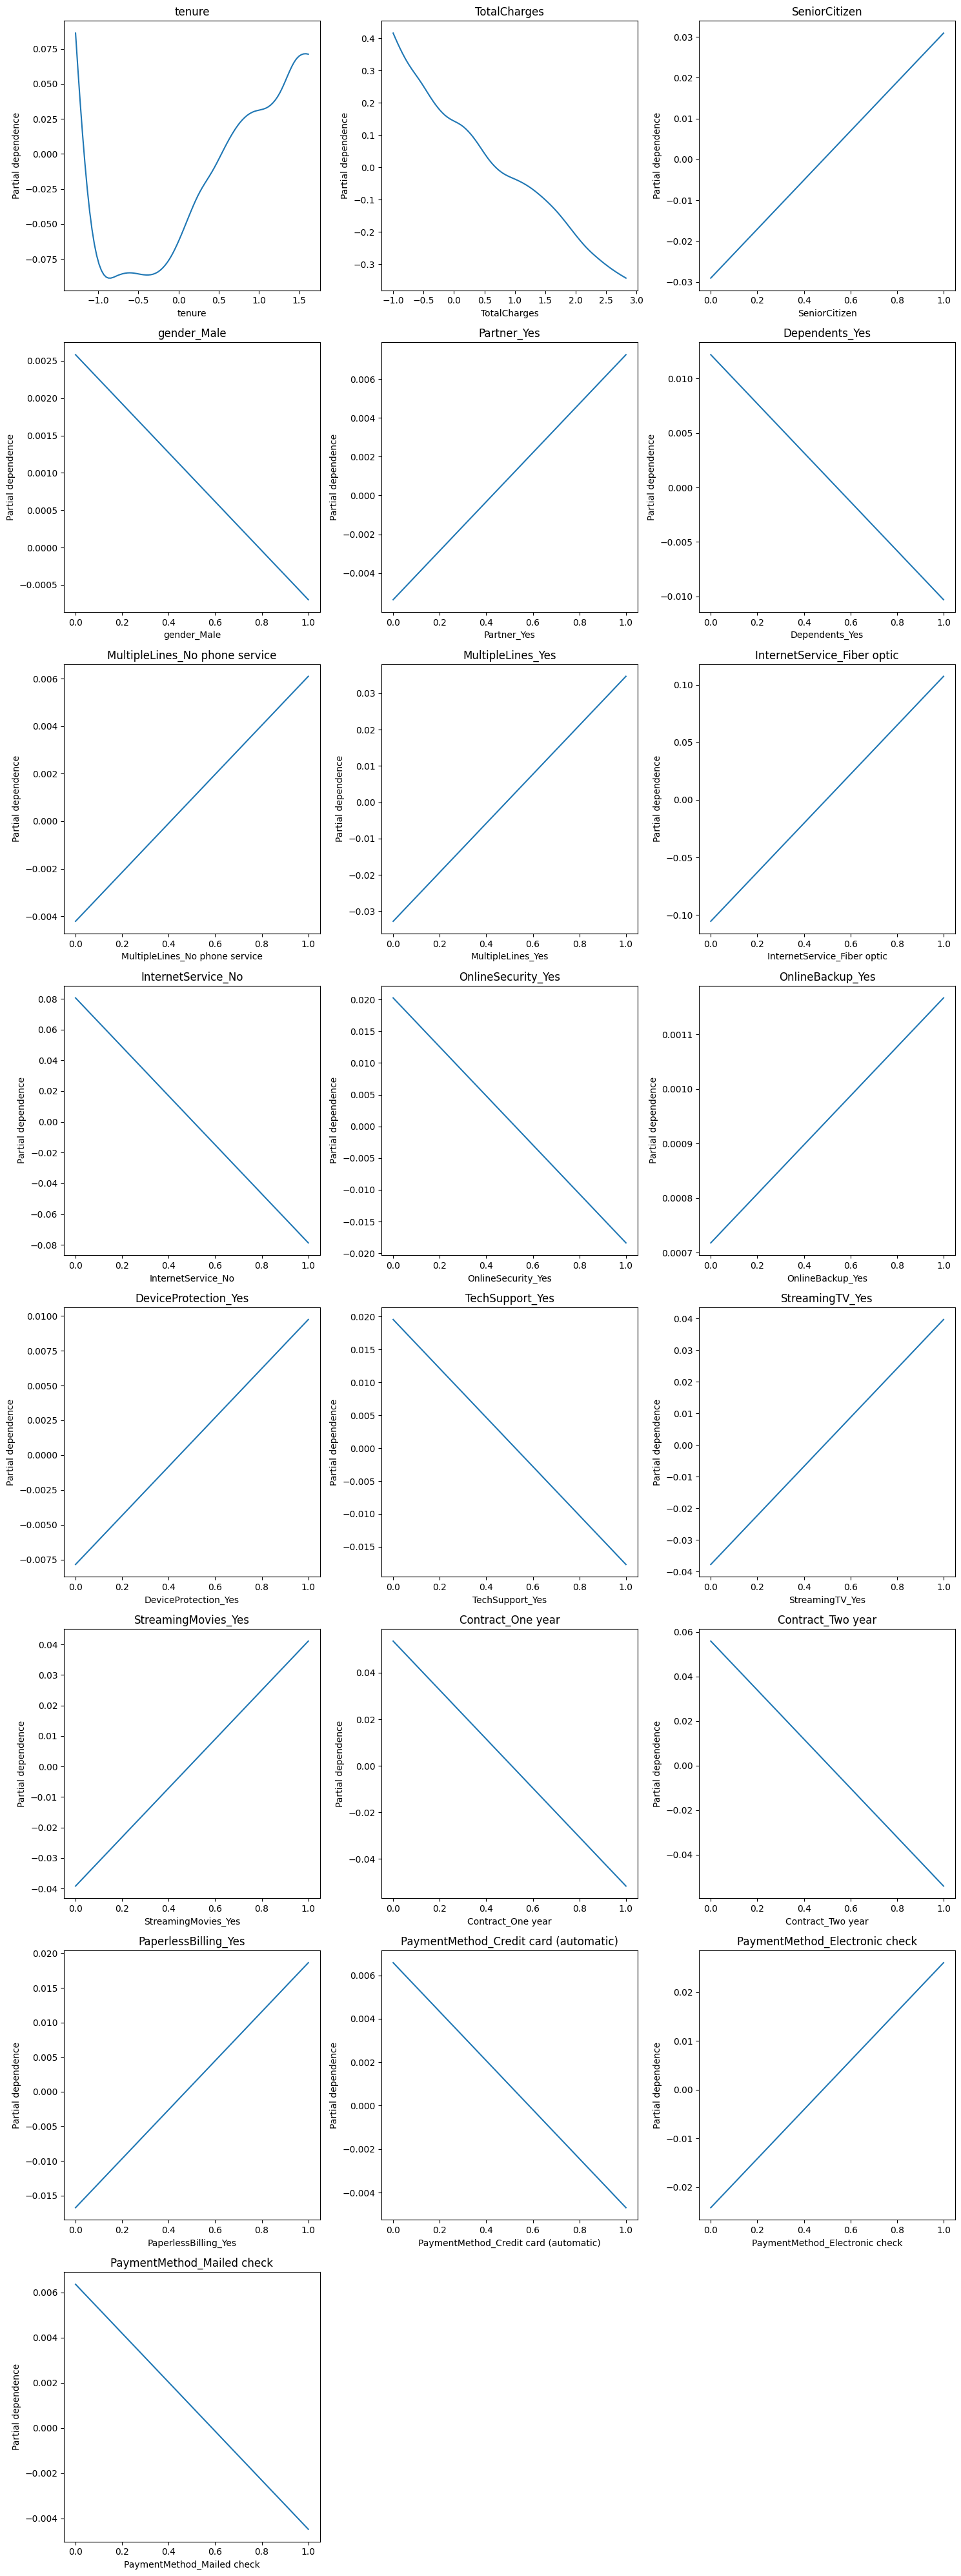

In [51]:
import math

# Determine the number of rows and columns for subplots
num_features = len(feature_names)
rows = math.ceil(num_features / 3)

plt.figure(figsize=(15, 5 * rows))
subplot_index = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(rows, 3, subplot_index)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(feature_names[term.feature])
    plt.ylabel('Partial dependence')
    plt.xlabel(feature_names[term.feature])
    subplot_index += 1
plt.tight_layout()
plt.show()

1. From the graph, we can see each subplot shows how the feature on the x-axis affects the  probability of the target when other features are held constant.
2. For features like tenure and TotalCharges, the curves are smooth, showing the non-linear relationship between the feature and the target. Take Tenure as an example, a non-linear effect is observed where low values contribute positively, but higher values decrease the predicted target probability after a point.
3. For binary features, the graph shows a simple stepwise change between 0 and 1. Take InternetService_Fiber optic as an example, having fiber optic service seems to increase the predicted probability of the target.
4. We can determine the importance of feature according to the value change of the vertical axis. For example, features like tenure, TotalCharges, InternetService_Fiber optic, and Contract_years have substantial impacts on predictions.


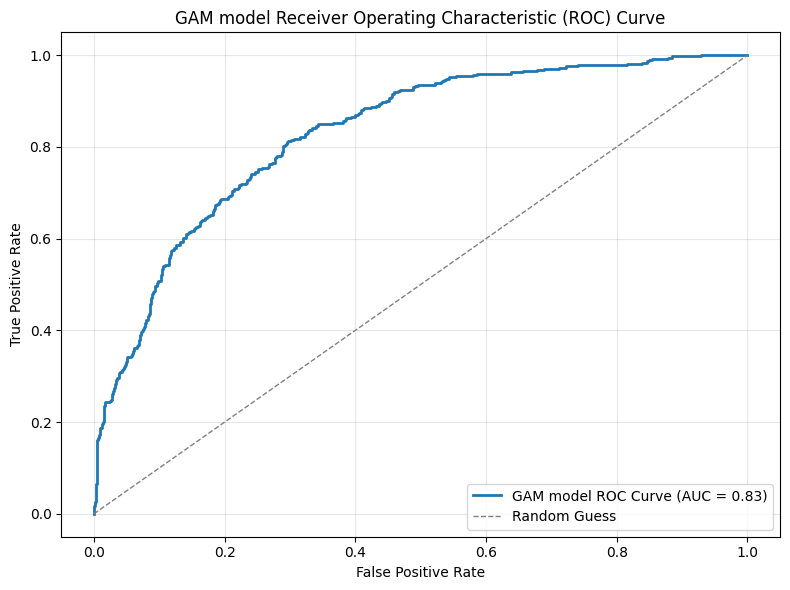

{'Model': 'GAM model', 'Accuracy': 0.7874911158493249, 'Precision': 0.6518218623481782, 'Recall': 0.4304812834224599, 'F1 Score': 0.5185185185185185, 'ROC AUC': 0.8303653239875552, 'Confusion Matrix': [[947, 86], [213, 161]]}


In [52]:
GAM_eval = evaluate_model(gam, X_train, X_test, y_train, y_test, "GAM model")
print(GAM_eval)

###### We can see there are some differencces between Gam and logistic model(weighted)
1. Precision: GAM achieves higher precision for the positive class (0.6518 vs. 0.50), meaning it is more cautious about predicting positive churn, reducing false positives.
2. Recall: Weighted logistic regression excels in recall (0.79 vs. 0.4305), capturing more true positives but at the cost of higher false positives.
3. Accuracy: GAM has a slightly higher overall accuracy (0.7875 vs. 0.73).
4. F1 Score: Weighted logistic regression has a higher F1 score for the positive class (0.61 vs. 0.5185), making it better at balancing precision and recall.

## Comparisons

1. Linear Regression (including Ridge and Lasso):
* Strengths: (1) Predictions are transparent and easy to interpret as coefficients represent the linear relationship between features and the target variable. (2) Lasso regression helps with feature selection by shrinking less important feature coefficients to zero. (3) Ridge and Lasso can also address overfitting by penalizing large coefficients.
* Weaknesses: (1) Linear regression assumes relationships between features and the target are linear, which is often unrealistic in real-world problems like customer churn. In addition, it has to satisfy many conditional assumptions and statistical distribution assumptions, such as Homoscedasticity, Normality etc. (2) It has poor performance for nonlinear data. When relationships are complex (like relationships in this dataset), accuracy decreases. (3) The interpretation of a weight depends on other features being held constant.
2. Logistic Regression (Iincluding Weighted Logistic Regression)
* Strengths: (1) Easy to interpret, though weights are multiplicative (log-odds). (2) The weighted version helps mitigate imbalanced datasets by assigning different penalties to classes. (3) Provides probabilities in addition to classifications, aiding in decision-making. (4) Performs best among the three models for the variable of interest to us (churn=1), with the highest recall rate and f1 score.
* Weakness: (1) Like linear regression, logistic regression is subject to many condition. For example, it assumes linear relationships between features and the log-odds of the target variable. (2) Features that perfectly separate classes can prevent model convergence.
3. GAM (Generalized Additive Model)
* Strengths: (1) Captures nonlinear relationships between features and the target variable, improving predictive performance. (2) Retains partial transparency by allowing visualization of the effect of each feature on the target. (3) Has the highest predictive power due to its highest accuracy of the three models
* Weakness: (1) More computationally intensive and less interpretable than linear models. (2) Requires careful tuning of smoothing parameters to avoid overfitting.

## Recommondations

#### The following models are recommended in order
1. When the priority is to identify as many churners as possible while requiring a certain level of interpretability, use Weighted Logistic Regression. It handles imbalanced data well and is straightforward to explain to stakeholders. Additionally, it performs well in predicting the variables we are most interested in.
2. For overall predictive power, use GAM. It can model complex, nonlinear relationships, making it more accurate for overall customer churn prediction.
3. Linear regressiona are not recommended due to its inability to handle nonlinear patterns and poor predictive power. However, lasso can be used for feature selection to identify important predictors.
#### In addition to the models already explored, several other options can be applied to the customer churn dataset, depending on priorities such as accuracy, interpretability, and complexity. For predictive performance, Gradient Boosting models like XGBoost or Random Forests are excellent choices, as they handle non-linear relationships effectively. If interpretability is crucial, Decision Trees can also provide clear insights into churn drivers. For smaller datasets, Bayesian Models or SVMs may be useful. Meanwhile, Neural Networks are a powerful option for large datasets. Overall, the choice of the model should align with business goals.